# Sample of Market Volatility

# Data generation


yfinance offers a threaded and Pythonic way to download market data from Yahoo!Ⓡ finance.

In [17]:
import numpy as np
import pandas as pd
import yfinance as yf

# Download historical data for a few example assets
assets = ['MSFT', 'BTC-USD', 'ETH-USD', 'USDT-USD']
data = yf.download(assets, start="2020-01-01", end="2023-01-01")['Adj Close']
returns = data.pct_change().dropna()
market_returns = yf.download('^GSPC', start="2020-01-01", end="2023-01-01")['Adj Close'].pct_change().dropna()

data.head()

[*********************100%%**********************]  4 of 4 completed
[*********************100%%**********************]  1 of 1 completed


Ticker,BTC-USD,ETH-USD,MSFT,USDT-USD
Date,,,,
2020-01-01,7200.174316,130.802002,NaN,0.999836
2020-01-02,6985.470215,127.410179,154.215668,1.001565
2020-01-03,7344.884277,134.171707,152.295395,1.004192
2020-01-04,7410.656738,135.069366,NaN,1.007472
2020-01-05,7411.317383,136.276779,NaN,1.006197


## Volatility Calculation

In [18]:
# Standard Deviation
volatility = returns.std()

# Annualized Volatility
annualized_volatility = volatility * np.sqrt(252)
annualized_volatility


Ticker
BTC-USD     0.602467
ETH-USD     0.802178
MSFT        0.288743
USDT-USD    0.052046
dtype: float64

## Historical Drawdown

In [19]:
def max_drawdown(returns):
    cumulative = (1 + returns).cumprod()
    peak = cumulative.cummax()
    drawdown = (cumulative - peak) / peak
    return drawdown.min()

drawdowns = returns.apply(max_drawdown)
drawdowns

Ticker
BTC-USD    -0.766346
ETH-USD    -0.793512
MSFT       -0.371485
USDT-USD   -0.075302
dtype: float64

## Beta Coefficient


In [20]:
def calculate_beta(returns, market_returns):
    covariance = returns.cov(market_returns)
    market_variance = market_returns.var()
    beta = covariance / market_variance
    return beta

betas = returns.apply(lambda x: calculate_beta(x, market_returns))
betas

Ticker
BTC-USD     1.068543
ETH-USD     1.373727
MSFT        1.172799
USDT-USD   -0.051275
dtype: float64

## Correlation Analysis

In [21]:
correlation_matrix = returns.corr()
correlation_matrix


Ticker,BTC-USD,ETH-USD,MSFT,USDT-USD
Ticker,,,,
BTC-USD,1.000000,0.822310,0.360478,-0.168010
ETH-USD,0.822310,1.000000,0.342494,-0.171702
MSFT,0.360478,0.342494,1.000000,-0.190877
USDT-USD,-0.168010,-0.171702,-0.190877,1.000000


## Complexity-Entropy Causality Plane

AntroPy is a Python 3 package providing several time-efficient algorithms for computing the complexity of time-series.

In [22]:
import antropy as ant

def permutation_entropy(time_series, emb_dim):
    return ant.perm_entropy(time_series, order=emb_dim)

permutation_entropies = returns.apply(lambda x: permutation_entropy(x.values, 3))
permutation_entropies


Ticker
BTC-USD     2.582416
ETH-USD     2.582628
MSFT        2.520278
USDT-USD    2.576911
dtype: float64

## Application

In [23]:
# Categorization of Pools
risk_levels = pd.DataFrame({
    'Volatility': annualized_volatility,
    'Drawdown': drawdowns,
    'Beta': betas,
    'Complexity': permutation_entropies
})

risk_levels['RiskCategory'] = 'Low'

risk_levels.loc[(risk_levels['Volatility'] > risk_levels['Volatility'].quantile(0.33)) & 
                (risk_levels['Volatility'] <= risk_levels['Volatility'].quantile(0.66)) & 
                (risk_levels['Drawdown'] >= risk_levels['Drawdown'].quantile(0.33)) & 
                (risk_levels['Drawdown'] <= risk_levels['Drawdown'].quantile(0.66)) & 
                (risk_levels['Beta'] <= 1) & 
                (risk_levels['Complexity'] <= risk_levels['Complexity'].quantile(0.66)), 'RiskCategory'] = 'Medium'

risk_levels.loc[(risk_levels['Volatility'] > risk_levels['Volatility'].quantile(0.66)) | 
                (risk_levels['Drawdown'] < risk_levels['Drawdown'].quantile(0.33)) | 
                (risk_levels['Beta'] > 1) | 
                (risk_levels['Complexity'] > risk_levels['Complexity'].quantile(0.66)), 'RiskCategory'] = 'High'


risk_levels

,Volatility,Drawdown,Beta,Complexity,RiskCategory
Ticker,,,,,
BTC-USD,0.602467,-0.766346,1.068543,2.582416,High
ETH-USD,0.802178,-0.793512,1.373727,2.582628,High
MSFT,0.288743,-0.371485,1.172799,2.520278,High
USDT-USD,0.052046,-0.075302,-0.051275,2.576911,Low


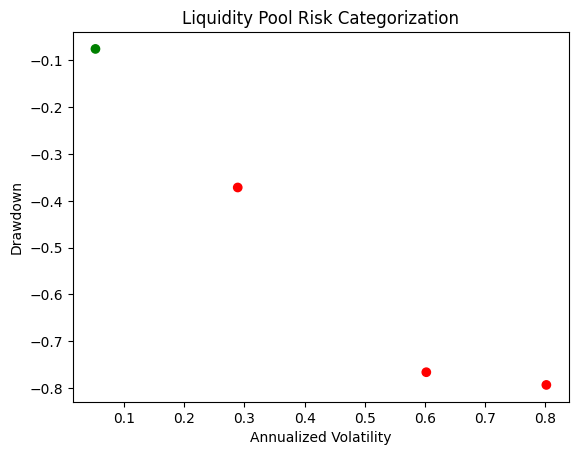

In [24]:
import matplotlib.pyplot as plt

plt.scatter(risk_levels['Volatility'], risk_levels['Drawdown'], c=risk_levels['RiskCategory'].map({'Low': 'green', 'Medium': 'yellow', 'High': 'red'}))
plt.xlabel('Annualized Volatility')
plt.ylabel('Drawdown')
plt.title('Liquidity Pool Risk Categorization')
plt.show()
